**<기존 논문과 다르게 적용한 부분>**
- 데이터셋: ImageNet -> CIFAR10
- 데이터 normalizer: RGB mean 뺌 -> mean 빼고, std으로 나눔
- batch size: 256 -> 32 (메모리문제)
- epoch: 74 -> 5 (데이터 크기 작음. 시간)
- weight init

# Data 로딩

In [1]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

- ImageNet 데이터셋은 **training 1.3M / validation 50K / testing 100K(label X)**으로 크기가 너무 큼 (469x387)
- CIFAR10 데이터셋은 **training 50K (training 40K, validation 10K) / tesing 10K**으로 크기 작음 (32x32)

In [2]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
    ]) 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(trainset, [40000, 10000])
trainloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
validloader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(trainset.data.shape)
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(len(trainloader), images.shape)

(50000, 32, 32, 3)
1250 torch.Size([32, 3, 224, 224])


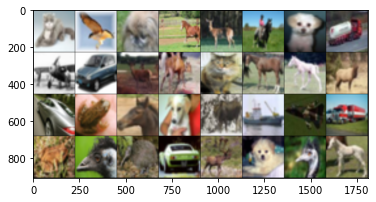

  cat  bird   dog horse  deer horse   dog truck plane   car  deer  deer   cat horse horse  deer   car  frog horse   dog  deer  ship plane truck  frog  bird  bird   car  deer   dog  bird horse


In [4]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
batch_size = 32
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

**Normalize Input하여 데이터분포를 고르게 해주어 gradient smooth하게 업데이트 되도록**

In [5]:
print(trainset.data.shape)
print(trainset.data.mean(axis=(0,1,2))/255)
print(trainset.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [6]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
    ]) 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(trainset, [40000, 10000])
trainloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
validloader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


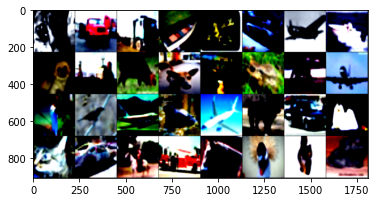

  cat truck truck  ship  frog   car plane  ship   dog  ship  deer   dog  deer  frog horse plane  bird  bird plane  frog plane horse   car   dog   cat   car horse truck horse  bird   cat   cat


In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

batch_size=32
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# 모델 구조

![모델구조](model_structure.png)

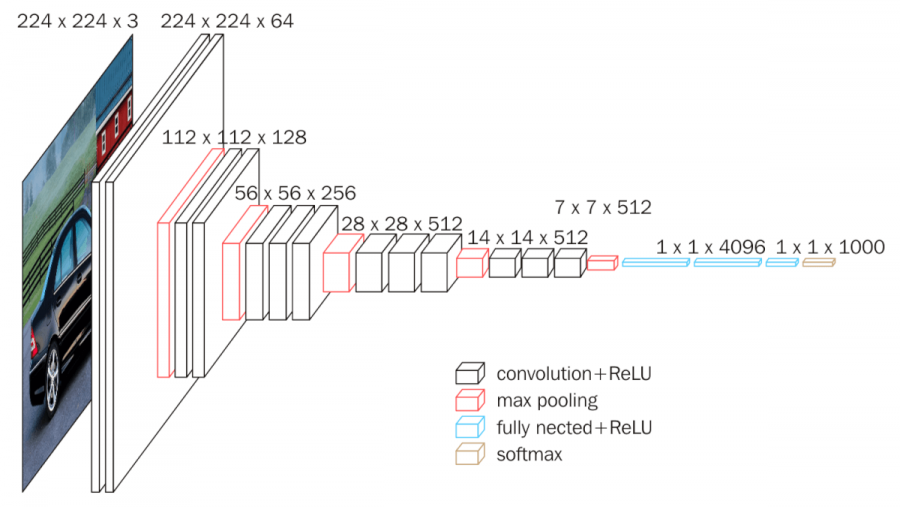

In [8]:
VGG_types = {
    ## num of channels, 'M':max-pooling
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGGNet(nn.Module):
    
    def __init__(self, num_classes=10, in_channels=3):
        super(VGGNet, self).__init__() #부모클래스의 __init__ 사용
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types['VGG19'])
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # 224/(2**5)=7, pooling: (I-P)/s+1=O (P=2,s=2) => O=I/2
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
        self._initialize_weights()

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                           #nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]
        
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules(): #각 layer에 대해
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n)) # He Normal Initialization
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = self.conv_layers(x) 
        x = x.reshape(x.shape[0], -1) #[32, 512, 7, 7] > [32, 25088]
        x = self.classifier(x)
        return x

# 학습

In [9]:
model = VGGNet(num_classes=len(classes))
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

VGGNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): MaxPool2d(kernel_si

In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [11]:
lr = 1e-3
momentum = 0.9
wd_lambda = 5*(1e-4)
num_epoch = 5
print_batch = int(len(trainloader)/4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=wd_lambda)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1)

all_epoch_train_loss = np.array([])
all_epoch_val_loss = np.array([])

In [ ]:
for t in tqdm(range(num_epoch)):
    
    ### train ###
    losses = []
    running_loss = 0 # loss 출력용
    running_loss_sum_per_epoch = 0
    total_images = 0 # 정확도 출력용
    correct_images = 0 # 정확도 출력용
    
    for i, data in enumerate(trainloader):
        images, labels = data
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)

        # forward
        outputs = model(images)
        _, predicts = torch.max(outputs.data, 1) #max로 가장 큰 class값 찾기
        loss = criterion(outputs, labels)
        looses.append(loss.item())
        
        #backward
        loss.backward()
        
        # graident descent
        optimizer.step()
        optimizer.zero_grad()
        
        
        total_images += labels.size(0)
        correct_images += (predicts == labels).sum().item() #top-1 error
        running_loss += loss.data.item()
        running_loss_sum_per_epoch = running_loss + running_loss_sum_per_epoch
        
        if i % print_batch == 0:
            print('Epoch: %d, batch: %5d / loss: %.6f / Training accuracy: %.5f' %
                  (t + 1, i + 1, running_loss / print_batch, 100 * correct_images / total_images))
            running_loss = 0
            total_images = 0
            correct_images = 0

    all_epoch_train_loss = np.append(all_epoch_train_loss, running_loss_sum_per_epoch)
    print(f'Cost at epoch {t} is {mean_loss}')
    
    PATH = 'epoch{}.pth'.format(t)
    torch.save(model.state_dict(), PATH)
    
    
    ### validation ###
    val_loss_sum_per_epoch = 0
    total_images = 0 # 정확도 출력용
    correct_images = 0 # 정확도 출력용
    
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images, labels = data
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들 off
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            val_loss = criterion(outputs, labels)
            val_loss_sum_per_epoch += val_loss
            total_images += labels.size(0)
            correct_images += (predicts == labels).sum().item()
            
            scheduler.step(val_loss)
            
    all_epoch_val_loss = np.append(all_epoch_val_loss, val_loss_sum_per_epoch)
    print('Epoch %d / loss: %.6f / Validation accuracy: %.5f' %
                  (t + 1, val_loss_sum_per_epoch / len(val_set), 100 * correct_images / total_images))

print('Finished training.')

In [ ]:
### Loss plot ###
e = range(num_epochs)
plt.plot(e, all_epoch_train_loss.reshape(-1), color='red', linestyle='--', labels='Training Loss')
plt.plot(e, all_epoch_val_loss.reshape(-1), color='red', linestyle='--', labels='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 테스트

In [ ]:
### test ###
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
                
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))            
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i])) 